In this notebook, we demonstrate usage of SpotSweeper_py on a public VisiumHD dataset. Specifically, the sample is taken from a human female breast cancer FFPE tissue block. The data summary could be obtained here: https://www.10xgenomics.com/datasets/visium-hd-cytassist-gene-expression-libraries-human-breast-cancer-ffpe-if/

To get started with the analysis, we process the dataset and convert into AnnData object.

In [1]:
from spatialdata_io import visium_hd
import spatialdata as sd

sdata = visium_hd("/users/xchen5/paper_spotsweeperpy/VisiumHD/", dataset_id = "Visium_HD_Human_Breast_Cancer_FFPE", fullres_image_file = "outs/spatial/tissue_hires_image.png")


/users/xchen5/.local/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/users/xchen5/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/users/xchen5/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/users/xchen5/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


We demonstrate the usage of SpotSweeper_py on **8um** bins first.

We first visualize the tissue section with respect to a selected QC metric (using pip-installable package **visiumhd-utils**). Then, we apply SpotSweeper and present its results, demonstrating the effect of the algorithm.

To start, we create violin plots to understand the flagged outliers from all metrics.

In [2]:
import visiumhd_utils.qc_plot as qp
qp.compute_qc_metrics(sdata, bin_size=8, mito_prefix="MT-")
adata = sdata.tables["square_008um"]

import numpy as np
from scipy.stats import median_abs_deviation

def is_outlier(vec, nmads=3, log=False, direction='both'):
    arr = np.log1p(vec) if log else np.asarray(vec)
    med = np.nanmedian(arr)
    mad = median_abs_deviation(arr, nan_policy='omit')
    lower = med - nmads * mad
    upper = med + nmads * mad
    if direction == 'lower':
        return arr < lower
    elif direction == 'higher':
        return arr > upper
    else:
        return (arr < lower) | (arr > upper)
    
adata.obs['low_counts_outlier'] = is_outlier(adata.obs['total_counts'], direction='lower')
adata.obs['low_log_counts_outlier'] = is_outlier(adata.obs['log_total_counts'], direction='lower')
adata.obs['high_mt_outlier']   = is_outlier(adata.obs['pct_counts_mt'], direction='higher')
adata.obs['low_genes_outlier'] = is_outlier(adata.obs['n_genes_by_counts'], direction='lower')

# combine into one global flag
adata.obs['all_metrics_outlier'] = (
    adata.obs['low_counts_outlier'] | adata.obs['low_log_counts_outlier'] | adata.obs['high_mt_outlier'] | adata.obs['low_genes_outlier']
)

print(adata.obs['low_counts_outlier'].value_counts())
print(adata.obs['low_log_counts_outlier'].value_counts())
print(adata.obs['high_mt_outlier'].value_counts())
print(adata.obs['low_genes_outlier'].value_counts())
print(adata.obs['all_metrics_outlier'].value_counts())

low_counts_outlier
False    663857
Name: count, dtype: int64
low_log_counts_outlier
False    649646
True      14211
Name: count, dtype: int64
high_mt_outlier
False    636623
True      27234
Name: count, dtype: int64
low_genes_outlier
False    663857
Name: count, dtype: int64
all_metrics_outlier
False    623103
True      40754
Name: count, dtype: int64


/tmp/ipykernel_2286200/2822335246.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Non-Outlier', 'Outlier'], fontsize=9)
/tmp/ipykernel_2286200/2822335246.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Non-Outlier', 'Outlier'], fontsize=9)
/tmp/ipykernel_2286200/2822335246.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Non-Outlier', 'Outlier'], fontsize=9)
/tmp/ipykernel_2286200/2822335246.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Non-Outlier', 'Outlier'], fontsize=9)


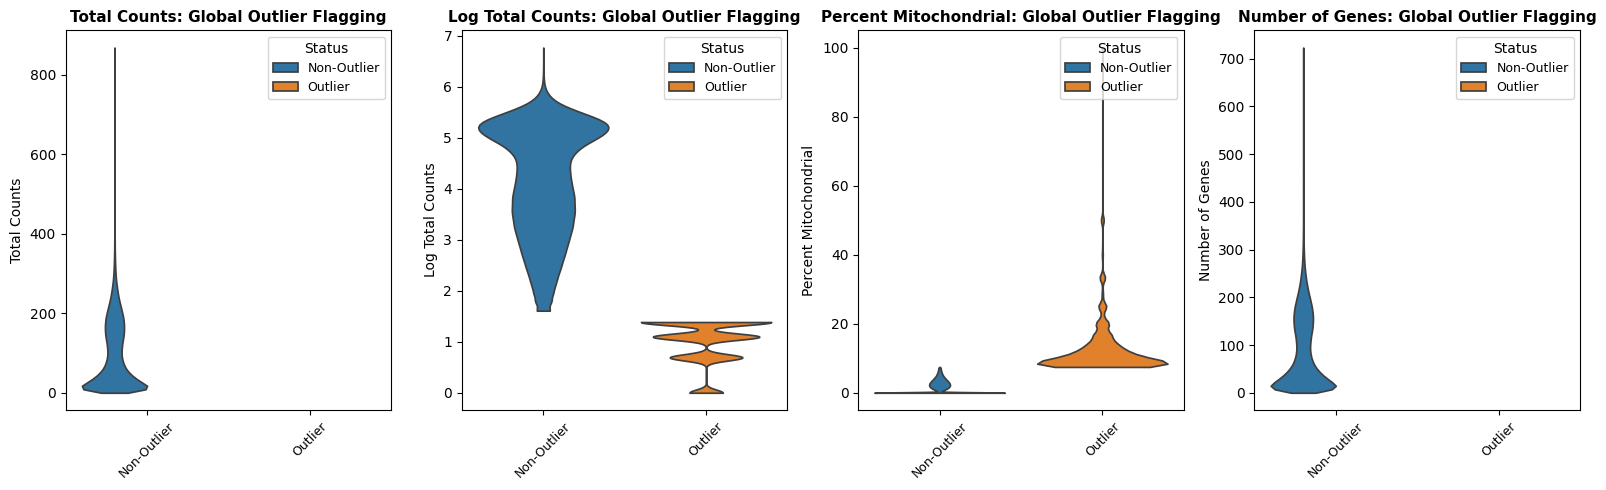

In [25]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

adata.var_names_make_unique()
for col in ['low_counts_outlier', 'low_log_counts_outlier', 'high_mt_outlier', 'low_genes_outlier']:
    adata.obs[col] = pd.Categorical(adata.obs[col], categories=[False, True])

# metric, flag, readable title, y-axis label
pairs = [
    ('total_counts', 'low_counts_outlier', 'Total Counts: Global Outlier Flagging', 'Total Counts'),
    ('log_total_counts', 'low_log_counts_outlier', 'Log Total Counts: Global Outlier Flagging', 'Log Total Counts'),
    ('pct_counts_mt', 'high_mt_outlier', 'Percent Mitochondrial: Global Outlier Flagging', 'Percent Mitochondrial'),
    ('n_genes_by_counts', 'low_genes_outlier', 'Number of Genes: Global Outlier Flagging', 'Number of Genes')
]

fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for ax, (metric, flag, title, ylabel) in zip(axes, pairs):
    sc.pl.violin(
        adata,
        keys=metric,
        groupby=flag,
        jitter=0.4,
        stripplot=False,
        rotation=45,
        multi_panel=False,
        ax=ax,
        show=False
    )
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=10)

    # Replace generic x-axis tick labels (True/False -> Outlier/Non-Outlier)
    ax.set_xticklabels(['Non-Outlier', 'Outlier'], fontsize=9)

    # Replace legend
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, ['Non-Outlier', 'Outlier'], title="Status", loc='upper right', fontsize=9, title_fontsize=10)

plt.tight_layout()
plt.show()


/tmp/ipykernel_2286200/979836042.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Non-Outlier', 'Outlier'], fontsize=9)


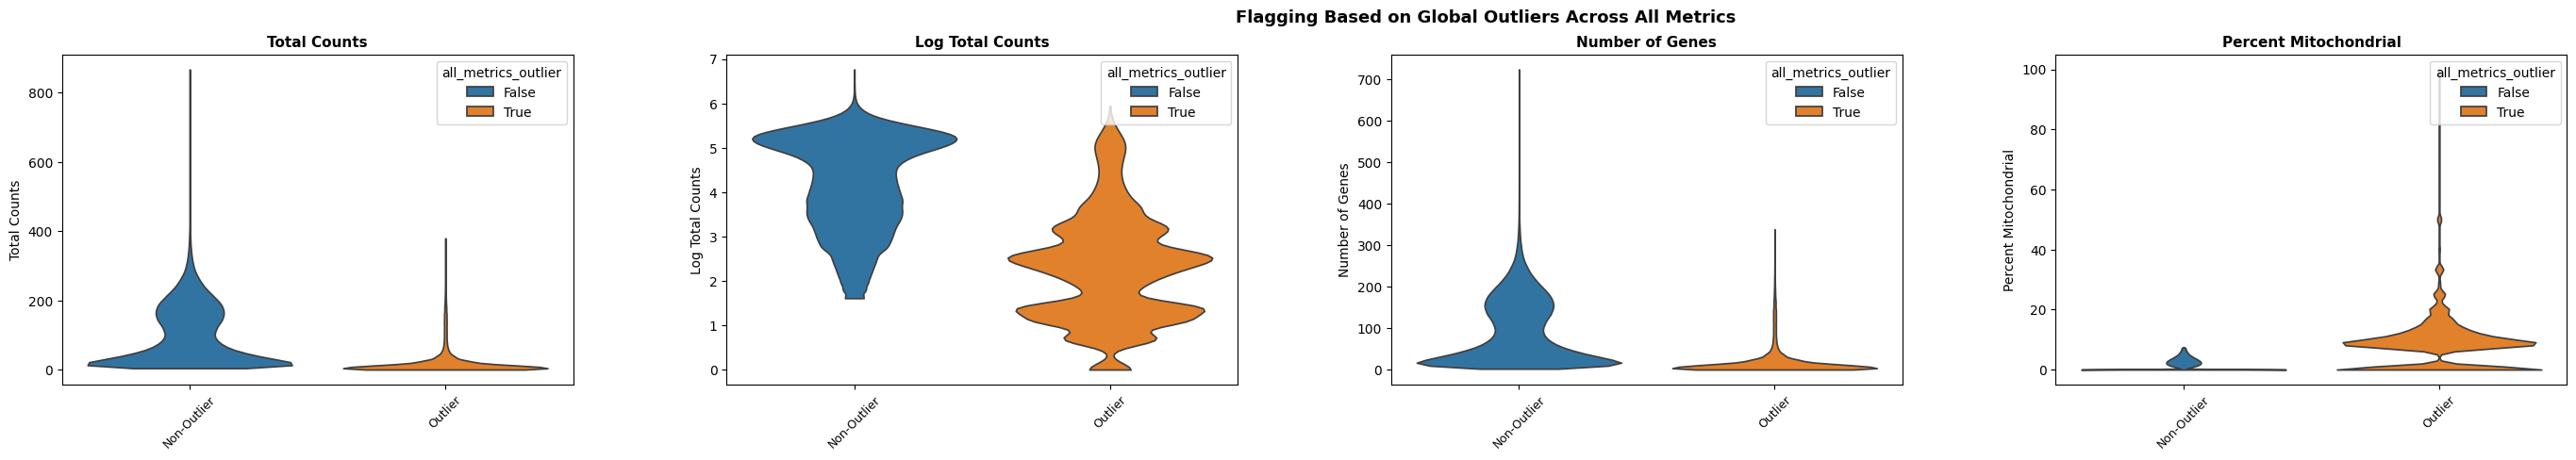

In [23]:
adata.obs['all_metrics_outlier'] = pd.Categorical(adata.obs['all_metrics_outlier'], categories=[False, True])

axes = sc.pl.violin(
    adata,
    keys=['total_counts', 'log_total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
    groupby='all_metrics_outlier',
    jitter=0.4,
    stripplot=False,
    rotation=45,
    multi_panel=True,
    show=False
)

fig = axes[0].figure
fig.suptitle("Flagging Based on Global Outliers Across All Metrics", fontsize=13, fontweight='bold')

# custom y-axis labels (match order of `keys`)
ylabs = ["Total Counts", "Log Total Counts", "Number of Genes", "Percent Mitochondrial"]

for ax, ylabel in zip(axes, ylabs):
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xlabel("")  # no redundant xlabel
    ax.set_xticklabels(['Non-Outlier', 'Outlier'], fontsize=9)
    ax.set_title(ylabel, fontsize=11, fontweight='bold') 

plt.show()

Local Outlier Violin Plots: (I ran this block retroactively, so need to run local outlier function first before creating the violin plots)

/tmp/ipykernel_2286200/3178247165.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Non-Outlier', 'Outlier'], fontsize=9)
/tmp/ipykernel_2286200/3178247165.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Non-Outlier', 'Outlier'], fontsize=9)
/tmp/ipykernel_2286200/3178247165.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Non-Outlier', 'Outlier'], fontsize=9)
/tmp/ipykernel_2286200/3178247165.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Non-Outlier', 'Outlier'], fontsize=9)


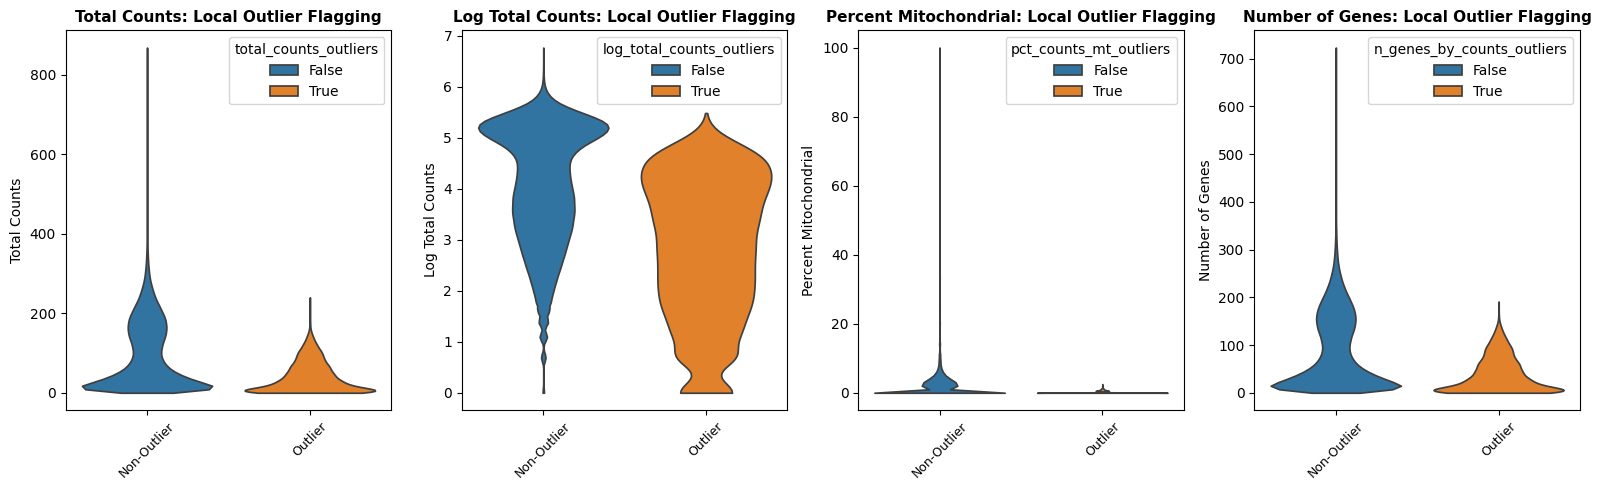

total_counts_outliers
False    657052
True       6805
Name: count, dtype: int64
log_total_counts_outliers
False    653547
True      10310
Name: count, dtype: int64
pct_counts_mt_outliers
False    657899
True       5958
Name: count, dtype: int64
n_genes_by_counts_outliers
False    656862
True       6995
Name: count, dtype: int64
all_local_metrics_outliers
False    647906
True      15951
Name: count, dtype: int64


/tmp/ipykernel_2286200/3178247165.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Non-Outlier', 'Outlier'], fontsize=9)
/tmp/ipykernel_2286200/3178247165.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


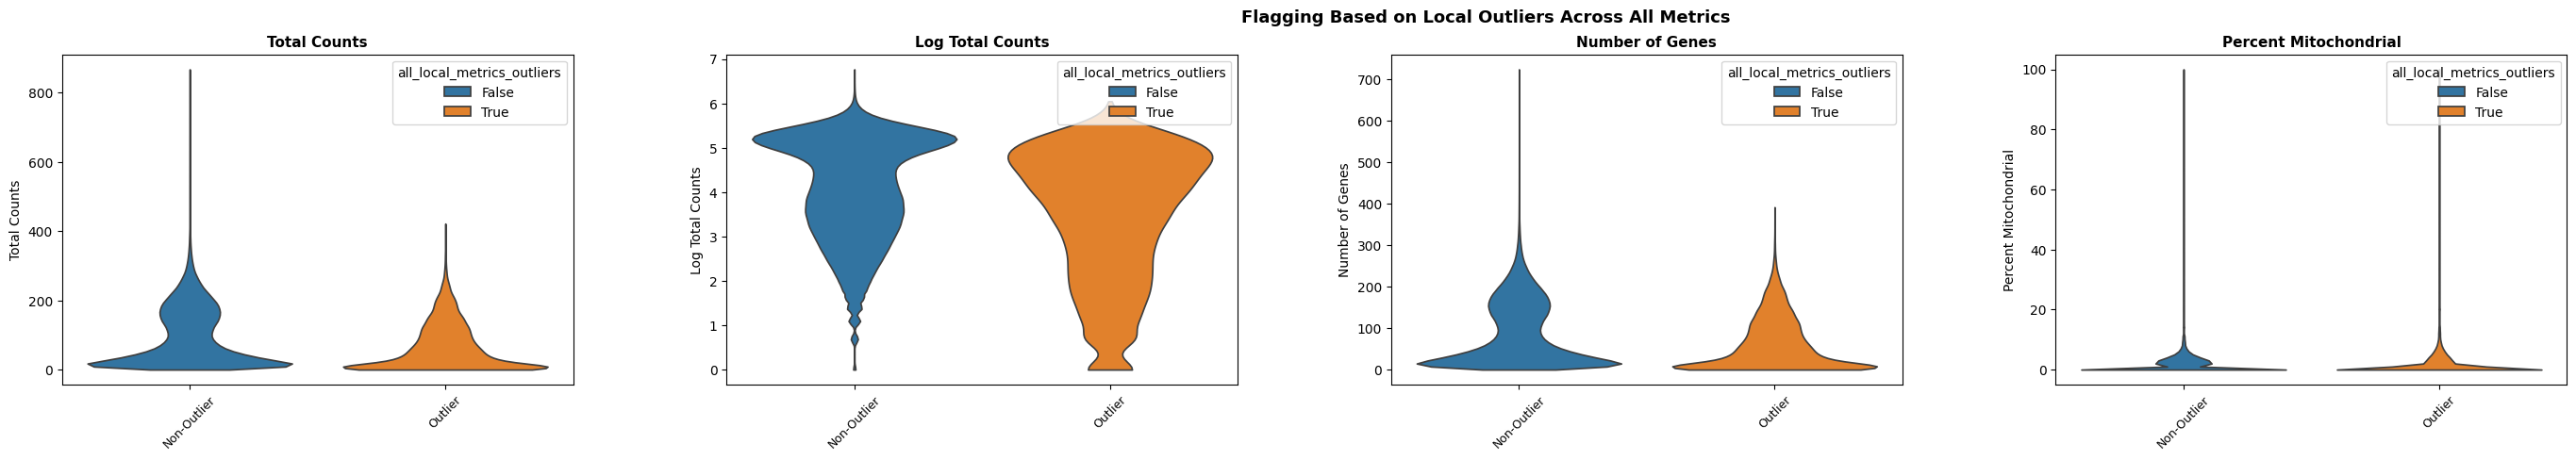

In [26]:
adata.var_names_make_unique()
for col in ['total_counts_outliers', 'log_total_counts_outliers', 'n_genes_by_counts_outliers', 'pct_counts_mt_outliers']:
    adata.obs[col] = pd.Categorical(adata.obs[col], categories=[False, True])

# Define metric–flag mapping
pairs = [
    ('total_counts', 'total_counts_outliers', 'Total Counts'),
    ('log_total_counts', 'log_total_counts_outliers', 'Log Total Counts'),
    ('pct_counts_mt', 'pct_counts_mt_outliers', 'Percent Mitochondrial'),
    ('n_genes_by_counts', 'n_genes_by_counts_outliers', 'Number of Genes')
]

# Create 4-panel figure
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for ax, (metric, flag, label) in zip(axes, pairs):
    sc.pl.violin(
        adata,
        keys=metric,
        groupby=flag,
        jitter=0.4,
        stripplot=False,
        rotation=45,
        multi_panel=False,
        ax=ax,
        show=False
    )
    ax.set_title(f"{label}: Local Outlier Flagging", fontsize=11, fontweight='bold')
    ax.set_ylabel(label, fontsize=10)
    ax.set_xlabel("")
    ax.set_xticklabels(['Non-Outlier', 'Outlier'], fontsize=9)

plt.tight_layout()
plt.show()

# combine into one global flag
adata.obs['all_local_metrics_outliers'] = (
    adata.obs['total_counts_outliers'].astype(bool)
    | adata.obs['log_total_counts_outliers'].astype(bool)
    | adata.obs['pct_counts_mt_outliers'].astype(bool)
    | adata.obs['n_genes_by_counts_outliers'].astype(bool)
)

print(adata.obs['total_counts_outliers'].value_counts())
print(adata.obs['log_total_counts_outliers'].value_counts())
print(adata.obs['pct_counts_mt_outliers'].value_counts())
print(adata.obs['n_genes_by_counts_outliers'].value_counts())
print(adata.obs['all_local_metrics_outliers'].value_counts())

adata.obs['all_local_metrics_outliers'] = pd.Categorical(adata.obs['all_local_metrics_outliers'], categories=[False, True])

axes = sc.pl.violin(
    adata,
    keys=['total_counts', 'log_total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
    groupby='all_local_metrics_outliers',  # group by TRUE/FALSE
    jitter=0.4,
    stripplot=False,
    rotation=45,
    multi_panel=True,
    show=False
)

fig = axes[0].figure
fig.suptitle("Flagging Based on Local Outliers Across All Metrics", fontsize=13, fontweight='bold')

for ax, label in zip(axes, ['Total Counts', 'Log Total Counts', 'Number of Genes', 'Percent Mitochondrial']):
    ax.set_title(label, fontsize=11, fontweight='bold')
    ax.set_ylabel(label, fontsize=10)
    ax.set_xlabel("")
    ax.set_xticklabels(['Non-Outlier', 'Outlier'], fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**Total Counts**

Spotplot:

/users/xchen5/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/users/xchen5/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     Using 'datashader' backend with 'max' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' do disable this behaviour.   
INFO     Using the datashader reduction "max". "max" will give an output very close to the matplotlib result.      
INFO     alpha component of given RGBA value for outline color is discarded, because outline_alpha takes precedent.


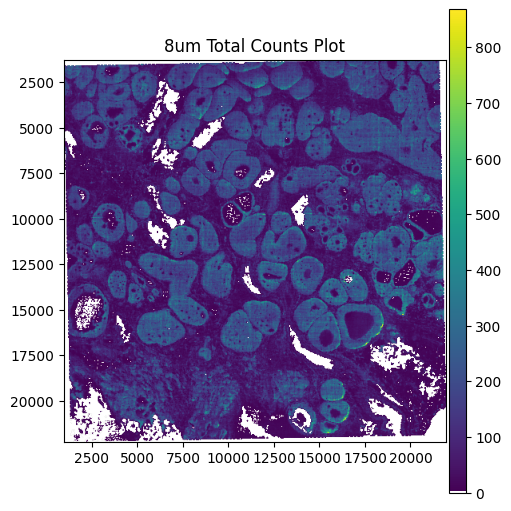

In [5]:
import visiumhd_utils.qc_plot as qp
qp.compute_qc_metrics(sdata, bin_size=8, mito_prefix="MT-")
qp.plot_qc_metrics(sdata, "Visium_HD_Human_Breast_Cancer_FFPE", "total_counts", bin_size = 8, figsize=(5,5), title = "8um Total Counts Plot")

Global QC Plot:

Colored = 0 / 663,857 (0.00%)


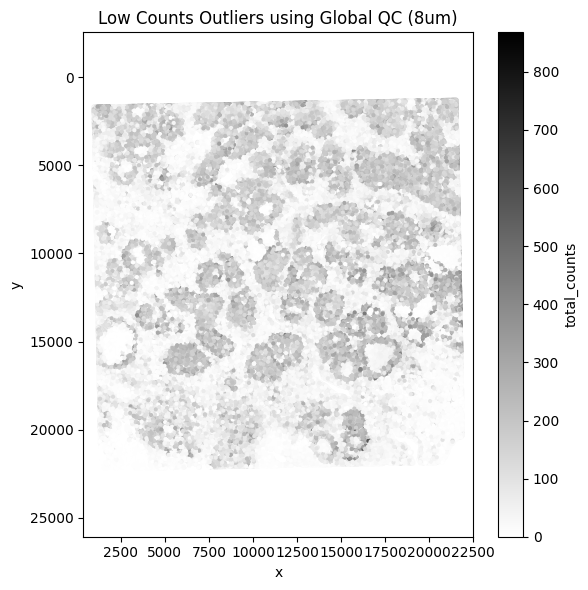

In [6]:
from typing import Optional, Sequence

def plot_qc_metric_with_outliers(
    adata,
    sample_id: str = "region",
    sample: Optional[str] = None,
    metric: str = "total_counts",
    outliers: str = "qc_outlier",
    point_size: float = 2,
    colors: Sequence[str] = ("white", "black"),
    stroke: float = 1.0,
    coord_key: str = "spatial",
    title_prefix: str = "QC Metric",
    title: Optional[str] = None,  # customizable title
):
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from matplotlib.colors import LinearSegmentedColormap

    # Select sample
    if sample is None:
        sample = adata.obs[sample_id].unique()[0]
    mask = np.array(adata.obs[sample_id] == sample)
    adata_sub = adata[mask].copy()

    # Build dataframe
    coords = np.array(adata_sub.obsm[coord_key])
    df = pd.DataFrame(coords, columns=["x", "y"], index=adata_sub.obs_names)
    df[metric] = adata_sub.obs[metric].astype(float)
    df["outlier"] = adata_sub.obs[outliers].astype(bool)
    
    # Condition: nonzero counts & outliers
    df["color_condition"] = (df[metric] > 0) & (df["outlier"])

    # Color scale
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

    # Base plot
    plt.figure(figsize=(6, 6))
    base = plt.scatter(
        df["x"], df["y"],
        c=df[metric], cmap=cmap, s=point_size**2,
        linewidths=0, rasterized=True
    )

    # Highlighted overlay
    highlighted = df[df["color_condition"]]
    print(f"Colored = {len(highlighted):,} / {len(df):,} "
          f"({len(highlighted)/len(df)*100:.2f}%)")

    plt.scatter(
        highlighted["x"], highlighted["y"],
        facecolors="none",
        edgecolors="red",
        linewidths=stroke * 1.5,
        alpha=0.8,
        s=(point_size * 1.4) ** 2,
    )

    # Axes and labels
    plt.gca().invert_yaxis()
    plt.axis("equal")
    plt.colorbar(base, label=metric)

    # Title: use custom if provided
    if title is not None:
        plt.title(title)
    else:
        plt.title(f"Global {title_prefix}: {metric} ({sample})")

    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    return plt


plot_qc_metric_with_outliers(
    adata=adata,
    sample_id="region",
    sample="Visium_HD_Human_Breast_Cancer_FFPE_square_008um",
    metric="total_counts",
    outliers="low_counts_outlier",       # boolean column
    point_size=3,
    colors=("white", "black"),  # background color gradient
    stroke=0.8,
    title="Low Counts Outliers using Global QC (8um)"
)
plt.show()

Note no outliers flagged!

Then, we apply SpotSweeper on the 8um bins, with respect to the total counts metric. In the figure, the red spots are spots that are flagged as low outliers with respect to the total counts metric.  
Runtime on a compute node: 35.7 seconds.

<module 'matplotlib.pyplot' from '/jhpce/shared/jhpce/core/python/3.9.14/lib/python3.9/site-packages/matplotlib/pyplot.py'>

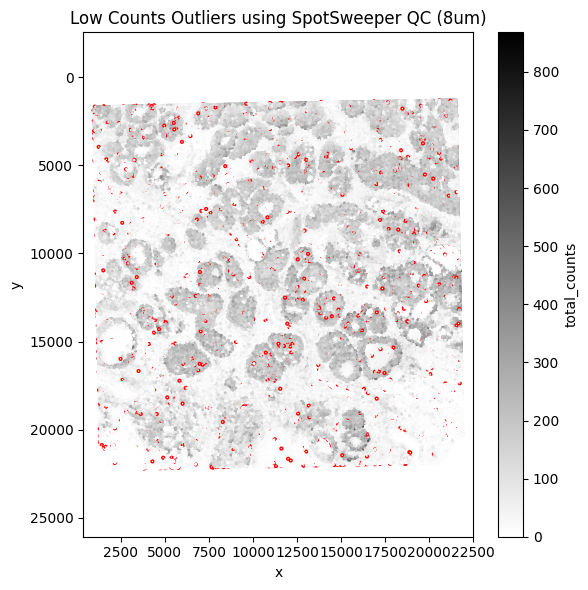

In [7]:
import spotsweeper.local_outliers as lo
import spotsweeper.plot_QC as plot_QC

adata = sdata.tables["square_008um"]
lo.local_outliers(adata, metric = "total_counts", sample_key = "region") # compute local outliers
plot_QC.plot_qc_metrics(adata,"region", metric = "total_counts", outliers="total_counts_outliers", title="Low Counts Outliers using SpotSweeper QC (8um)") # plot outliers

In [8]:
col = "total_counts_outliers"
print(adata.obs[col].value_counts())

total_counts_outliers
False    657052
True       6805
Name: count, dtype: int64


Flagged percentage: 6805/(6805+657052) = 1.02%

We then repeat for log total counts, number of genes by counts, and % mitochondrial counts metrics.

**Log Total Counts**

Spotplot:

/users/xchen5/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/users/xchen5/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     Using 'datashader' backend with 'max' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' do disable this behaviour.   
INFO     Using the datashader reduction "max". "max" will give an output very close to the matplotlib result.      
INFO     alpha component of given RGBA value for outline color is discarded, because outline_alpha takes precedent.


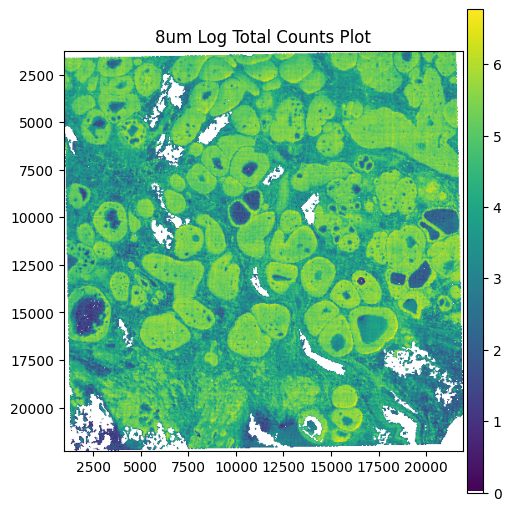

In [9]:
qp.plot_qc_metrics(sdata, "Visium_HD_Human_Breast_Cancer_FFPE", "log_total_counts", bin_size = 8, figsize=(5,5), title = "8um Log Total Counts Plot")

Global QC Plot:

Colored = 12,828 / 663,857 (1.93%)


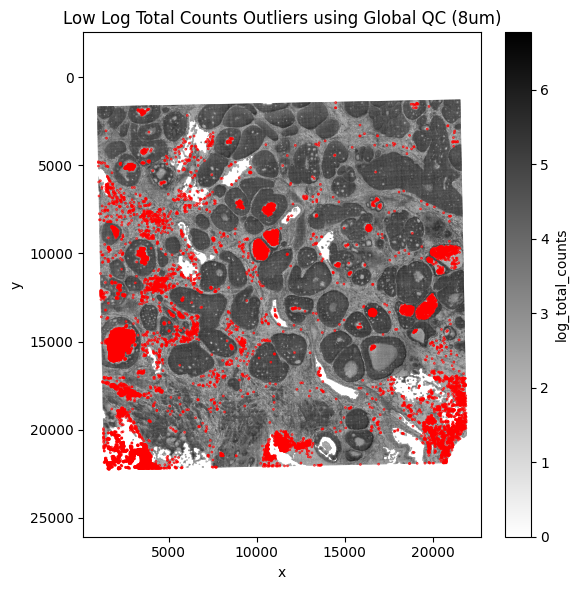

In [10]:
plot_qc_metric_with_outliers(
    adata=adata,
    sample_id="region",
    sample="Visium_HD_Human_Breast_Cancer_FFPE_square_008um",
    metric="log_total_counts",
    outliers="low_log_counts_outlier",       # boolean column
    point_size=0.5,
    colors=("white", "black"),  # background color gradient
    stroke=0.8,
    title="Low Log Total Counts Outliers using Global QC (8um)"
)
plt.show()

SpotSweeper Plot:

<module 'matplotlib.pyplot' from '/jhpce/shared/jhpce/core/python/3.9.14/lib/python3.9/site-packages/matplotlib/pyplot.py'>

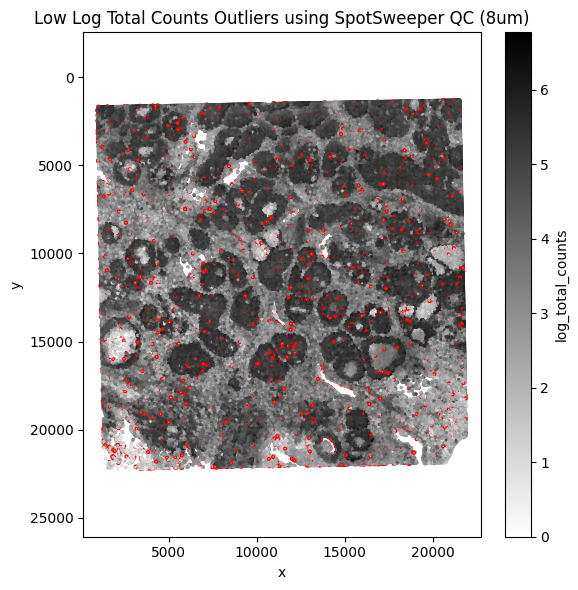

In [11]:
import spotsweeper.local_outliers as lo
import spotsweeper.plot_QC as plot_QC

lo.local_outliers(adata, metric = "log_total_counts", sample_key = "region") # compute local outliers
plot_QC.plot_qc_metrics(adata,"region", metric = "log_total_counts", outliers="log_total_counts_outliers", title="Low Log Total Counts Outliers using SpotSweeper QC (8um)") # plot outliers

In [12]:
col = "log_total_counts_outliers"
print(adata.obs[col].value_counts())

log_total_counts_outliers
False    653547
True      10310
Name: count, dtype: int64


Flagged percentage: 10310/(10310+653547) = 1.55%

**Number of genes by counts**

Spotplot:

/users/xchen5/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/users/xchen5/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     Using 'datashader' backend with 'max' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' do disable this behaviour.   
INFO     Using the datashader reduction "max". "max" will give an output very close to the matplotlib result.      
INFO     alpha component of given RGBA value for outline color is discarded, because outline_alpha takes precedent.


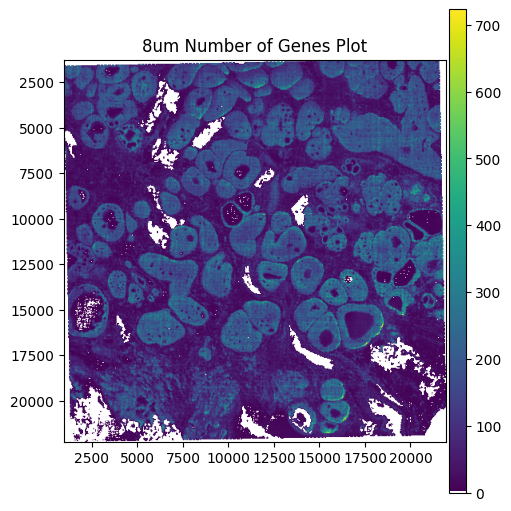

In [13]:
qp.plot_qc_metrics(sdata, "Visium_HD_Human_Breast_Cancer_FFPE", "n_genes_by_counts", bin_size = 8, figsize=(5,5), title = "8um Number of Genes Plot")

Global QC Plot:

Colored = 0 / 663,857 (0.00%)


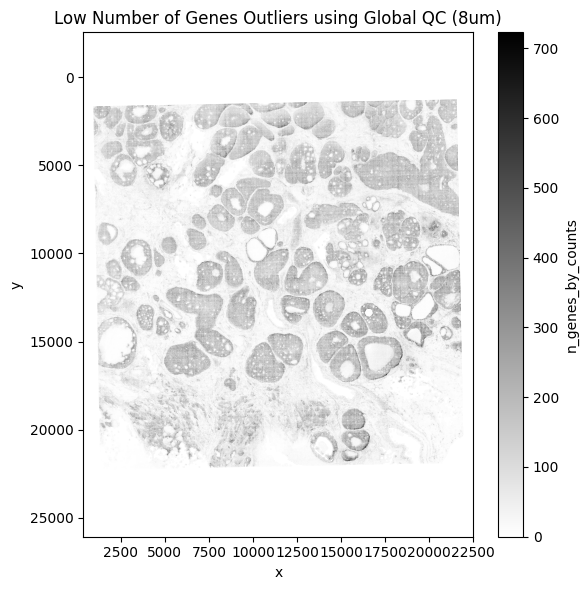

In [14]:
plot_qc_metric_with_outliers(
    adata=adata,
    sample_id="region",
    sample="Visium_HD_Human_Breast_Cancer_FFPE_square_008um",
    metric="n_genes_by_counts",
    outliers="low_genes_outlier",       # boolean column
    point_size=0.5,
    colors=("white", "black"),  # background color gradient
    stroke=0.8,
    title="Low Number of Genes Outliers using Global QC (8um)"
)
plt.show()

SpotSweeper plot:

<module 'matplotlib.pyplot' from '/jhpce/shared/jhpce/core/python/3.9.14/lib/python3.9/site-packages/matplotlib/pyplot.py'>

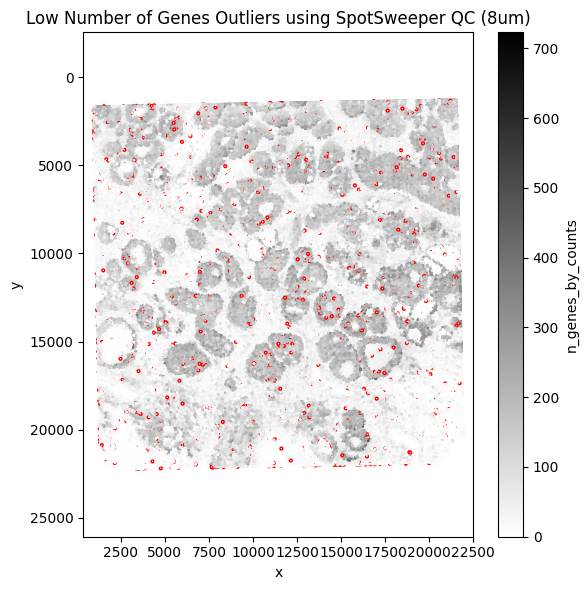

In [15]:
lo.local_outliers(adata, metric = "n_genes_by_counts", sample_key = "region") # compute local outliers
plot_QC.plot_qc_metrics(adata,"region", metric = "n_genes_by_counts", outliers="n_genes_by_counts_outliers", title="Low Number of Genes Outliers using SpotSweeper QC (8um)") # plot outliers

In [16]:
col = "n_genes_by_counts_outliers"
print(adata.obs[col].value_counts())

n_genes_by_counts_outliers
False    656862
True       6995
Name: count, dtype: int64


Flagged percentage: 6995/(656862+6995) = 1.05%

**% mitochondrial counts**

Spotplot:

/users/xchen5/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/users/xchen5/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


INFO     Using 'datashader' backend with 'max' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' do disable this behaviour.   
INFO     Using the datashader reduction "max". "max" will give an output very close to the matplotlib result.      
INFO     alpha component of given RGBA value for outline color is discarded, because outline_alpha takes precedent.


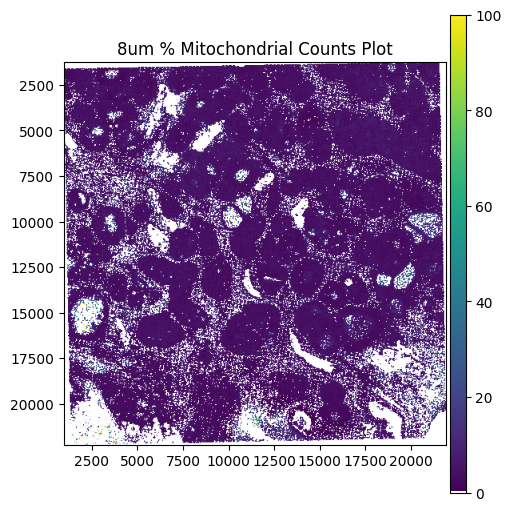

In [17]:
qp.plot_qc_metrics(sdata, "Visium_HD_Human_Breast_Cancer_FFPE", "pct_counts_mt", bin_size = 8, figsize=(5,5), title = "8um % Mitochondrial Counts Plot")

Global QC Plot:

Colored = 27,234 / 663,857 (4.10%)


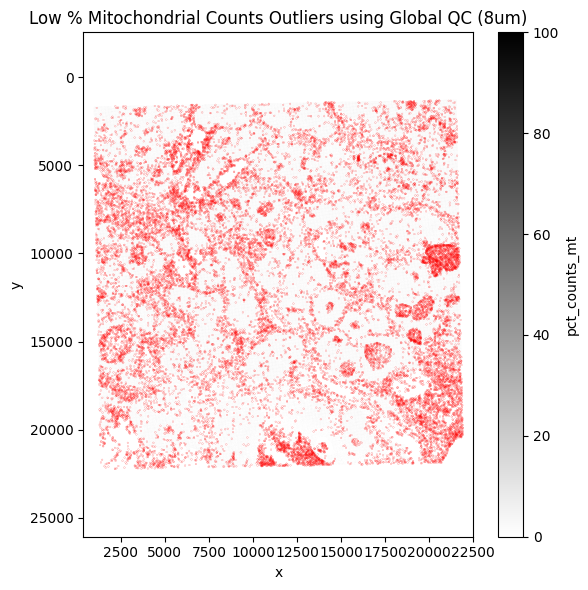

In [19]:
plot_qc_metric_with_outliers(
    adata=adata,
    sample_id="region",
    sample="Visium_HD_Human_Breast_Cancer_FFPE_square_008um",
    metric="pct_counts_mt",
    outliers="high_mt_outlier",       # boolean column
    point_size=0.1,
    colors=("white", "black"),  # background color gradient
    stroke=0.8,
    title="Low % Mitochondrial Counts Outliers using Global QC (8um)"
)
plt.show()

SpotSweeper plot:

<module 'matplotlib.pyplot' from '/jhpce/shared/jhpce/core/python/3.9.14/lib/python3.9/site-packages/matplotlib/pyplot.py'>

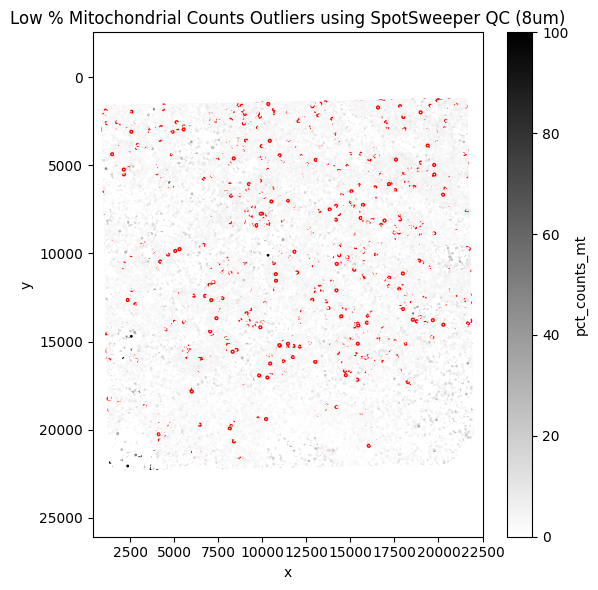

In [18]:
lo.local_outliers(adata, metric = "pct_counts_mt", sample_key = "region")
plot_QC.plot_qc_metrics(adata,"region", metric = "pct_counts_mt", outliers="pct_counts_mt_outliers", title="Low % Mitochondrial Counts Outliers using SpotSweeper QC (8um)") # plot outliers

In [20]:
col = "pct_counts_mt_outliers"
print(adata.obs[col].value_counts())

pct_counts_mt_outliers
False    657899
True       5958
Name: count, dtype: int64


Flagged percentage: 5958/(657899+5958) = 0.90%

We iterate on the **2um** bins. The violin plots are generated below to overview the data/outlier distribution.

In [35]:
# computing QC metrics and creating AnnData object
import visiumhd_utils.qc_plot as qp
qp.compute_qc_metrics(sdata, bin_size=2, mito_prefix="MT-")
bdata = sdata.tables["square_002um"]

In [39]:
# flag global outliers
bdata.obs['low_counts_outlier'] = is_outlier(bdata.obs['total_counts'], direction='lower')
bdata.obs['low_log_counts_outlier'] = is_outlier(bdata.obs['log_total_counts'], direction='lower')
bdata.obs['high_mt_outlier']   = is_outlier(bdata.obs['pct_counts_mt'], direction='higher')
bdata.obs['low_genes_outlier'] = is_outlier(bdata.obs['n_genes_by_counts'], direction='lower')

# combine into one global flag
bdata.obs['all_metrics_outlier'] = (
    bdata.obs['low_counts_outlier'] | bdata.obs['low_log_counts_outlier'] | bdata.obs['high_mt_outlier'] | bdata.obs['low_genes_outlier']
)

print(bdata.obs['low_counts_outlier'].value_counts())
print(bdata.obs['low_log_counts_outlier'].value_counts())
print(bdata.obs['high_mt_outlier'].value_counts())
print(bdata.obs['low_genes_outlier'].value_counts())
print(bdata.obs['all_metrics_outlier'].value_counts())

low_counts_outlier
False    10535119
Name: count, dtype: int64
low_log_counts_outlier
False    10535119
Name: count, dtype: int64
high_mt_outlier
False    9146980
True     1388139
Name: count, dtype: int64
low_genes_outlier
False    10535119
Name: count, dtype: int64
all_metrics_outlier
False    9146980
True     1388139
Name: count, dtype: int64


So at the 2um level, ONLY % mito flags outliers for global QC!

In [ ]:
bdata.var_names_make_unique()
for col in ['low_counts_outlier', 'low_log_counts_outlier', 'high_mt_outlier', 'low_genes_outlier']:
    bdata.obs[col] = pd.Categorical(bdata.obs[col])


# Define metric–flag mapping
pairs = [
    ('total_counts', 'low_counts_outlier'),
    ('log_total_counts', 'low_log_counts_outlier'),
    ('pct_counts_mt', 'high_mt_outlier'),
    ('n_genes_by_counts', 'low_genes_outlier')
]

# Create 4-panel figure
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for ax, (metric, flag) in zip(axes, pairs):
    sc.pl.violin(
        bdata,
        keys=metric,
        groupby=flag,
        jitter=0.4,
        stripplot=False,
        rotation=45,
        multi_panel=False,
        ax=ax,
        show=False
    )
    ax.set_title(f"Flagging based on outliers of {metric}")

plt.tight_layout()
plt.show()

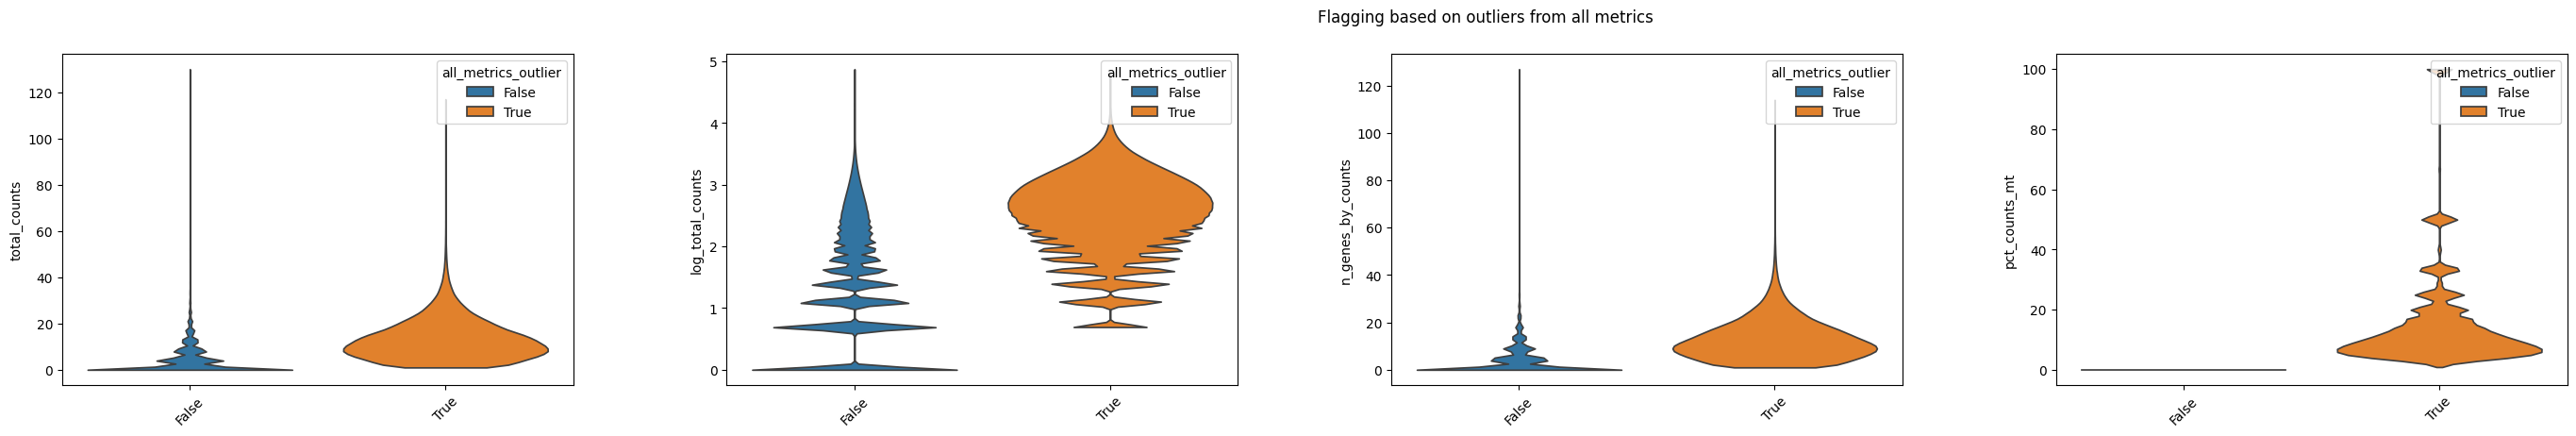

In [42]:
bdata.obs['all_metrics_outlier'] = pd.Categorical(bdata.obs['all_metrics_outlier'])

axes = sc.pl.violin(
    bdata,
    keys=['total_counts', 'log_total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
    groupby='all_metrics_outlier',  # group by TRUE/FALSE
    jitter=0.4,
    stripplot=False,
    rotation=45,
    multi_panel=True,
    show = False
)

fig = axes[0].figure
fig.suptitle("Flagging based on outliers from all metrics")
plt.show()

Note that the local outlier algorithm takes considerably longer time on 2um bins, and we document the time of each run below. We run each command on a compute node (CPU only) with 64G RAM.

Run-time for total counts metric (local outlier detection + plots of local outliers): 9m 32s.  
Run-time for log total counts metric: 10m 16s.  
Run-time for n genes by counts metric: 9m 16s.  
Run-time for %mito metric: 10m 22s.

As the run-time for Scanpy functions on 2um bins is too long, we choose to use hex-bins for spot plots of QC metrics. The custom function is below.

In [25]:
def plot_qc_hexbin(sdata, id, metric, bin_size=2, gridsize=200, cmap="viridis",
                   vmin=None, vmax=None, save_path=None, figsize=(5,5)):
    """
    alternative to qp.plot_qc_metrics() using matplotlib hexbin.

    Args:
        sdata: SpatialData object.
        id: dataset ID (used for naming).
        metric: column in sdata.tables["square_002um"].obs to visualize.
        bin_size: spatial bin size (2, 8, 16 µm).
        gridsize: number of hexagons across x-axis (controls resolution, default=200).
        cmap: colormap (default: viridis).
        vmin, vmax: color scale limits (optional).
        save_path: file path to save the figure (optional).
        figsize: tuple for figure size.
    """
    bin_str = f"{bin_size:03d}um"
    table_key = f"square_{bin_str}"
    adata = sdata.tables[table_key]

    if metric not in adata.obs:
        raise ValueError(f"Metric '{metric}' not found in sdata.tables['{table_key}'].obs")

    coords = adata.obsm["spatial"]
    values = adata.obs[metric].to_numpy()

    plt.figure(figsize=figsize)
    plt.hexbin(
        coords[:, 0], coords[:, 1],
        C=values,
        gridsize=gridsize,
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        reduce_C_function=np.mean  # average metric per hex
    )
    plt.axis("equal")
    plt.axis("off")
    plt.title(f"{id} – {bin_size}µm: {metric}")
    plt.colorbar(label=metric)
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
        plt.close()
    else:
        plt.show()

**Total Counts**  
Global QC does not flag any outliers.

Spot plot:

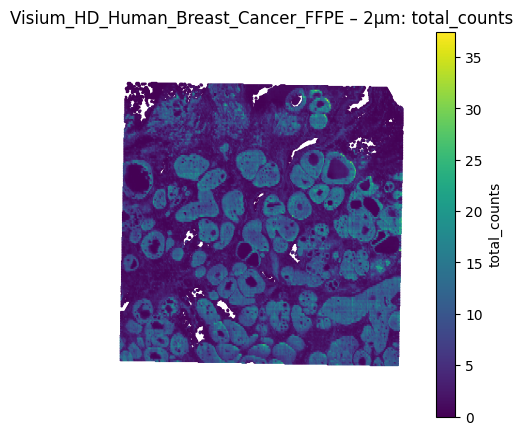

In [26]:
plot_qc_hexbin(
    sdata,
    id="Visium_HD_Human_Breast_Cancer_FFPE",
    metric="total_counts",
    bin_size=2,
    gridsize=300,  # finer control
    figsize=(5,5)
)

SpotSweeper plot:

<module 'matplotlib.pyplot' from '/jhpce/shared/jhpce/core/python/3.9.14/lib/python3.9/site-packages/matplotlib/pyplot.py'>

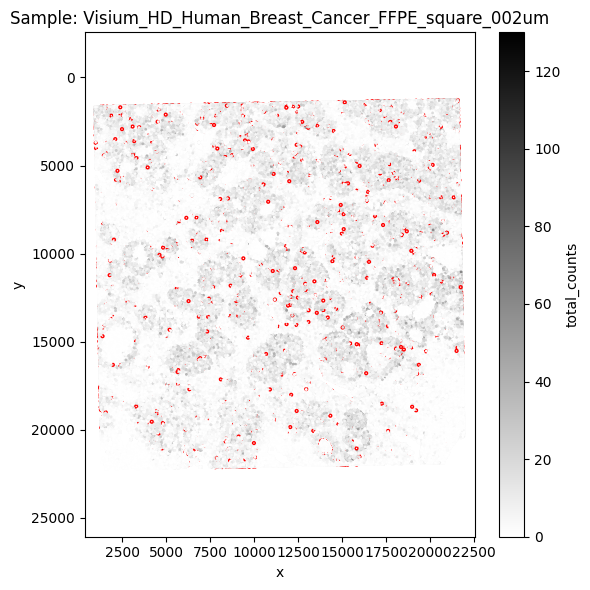

In [27]:
import spotsweeper.local_outliers as lo
import spotsweeper.plot_QC as plot_QC
# total counts
lo.local_outliers(bdata, metric = "total_counts", sample_key = "region") # compute local outliers
plot_QC.plot_qc_metrics(bdata,"region", metric = "total_counts", outliers="total_counts_outliers") # plot outliers

In [28]:
col = "total_counts_outliers"
print(bdata.obs[col].value_counts())

total_counts_outliers
False    10452246
True        82873
Name: count, dtype: int64


82873/(10452246+82873) = 0.79%

**Log Total Counts**  
Global QC does not flag any outliers.

Spot plot:

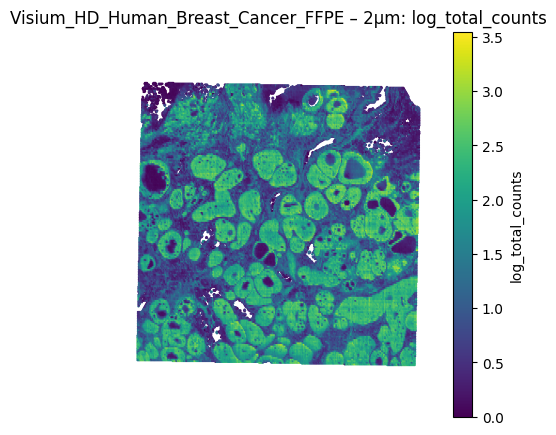

In [29]:
plot_qc_hexbin(
    sdata,
    id="Visium_HD_Human_Breast_Cancer_FFPE",
    metric="log_total_counts",
    bin_size=2,
    gridsize=300,  # finer control
    figsize=(5,5)
)

SpotSweeper plot:

<module 'matplotlib.pyplot' from '/jhpce/shared/jhpce/core/python/3.9.14/lib/python3.9/site-packages/matplotlib/pyplot.py'>

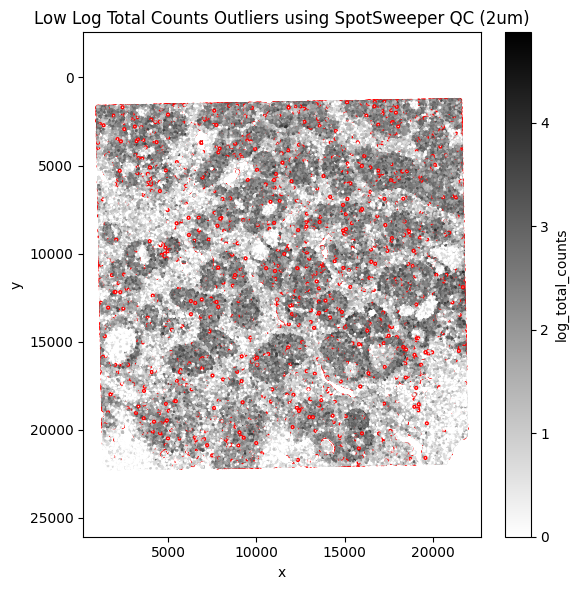

In [43]:
# log total counts
lo.local_outliers(bdata, metric = "log_total_counts", sample_key = "region") # compute local outliers
plot_QC.plot_qc_metrics(bdata,"region", metric = "log_total_counts", outliers="log_total_counts_outliers", title = "Low Log Total Counts Outliers using SpotSweeper QC (2um)") # plot outliers

In [31]:
col = "log_total_counts_outliers"
print(bdata.obs[col].value_counts())

log_total_counts_outliers
False    10291025
True       244094
Name: count, dtype: int64


244094/(10291025+244094) = 2.3%

**Number of Genes by Counts**  
Global QC does not flag any outliers.

Spot plot:

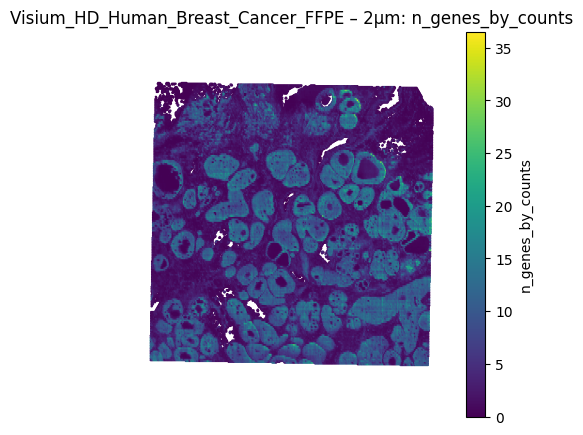

In [32]:
plot_qc_hexbin(
    sdata,
    id="Visium_HD_Human_Breast_Cancer_FFPE",
    metric="n_genes_by_counts",
    bin_size=2,
    gridsize=300,  # finer control
    figsize=(5,5)
)

Spotsweeper plot:

<module 'matplotlib.pyplot' from '/jhpce/shared/jhpce/core/python/3.9.14/lib/python3.9/site-packages/matplotlib/pyplot.py'>

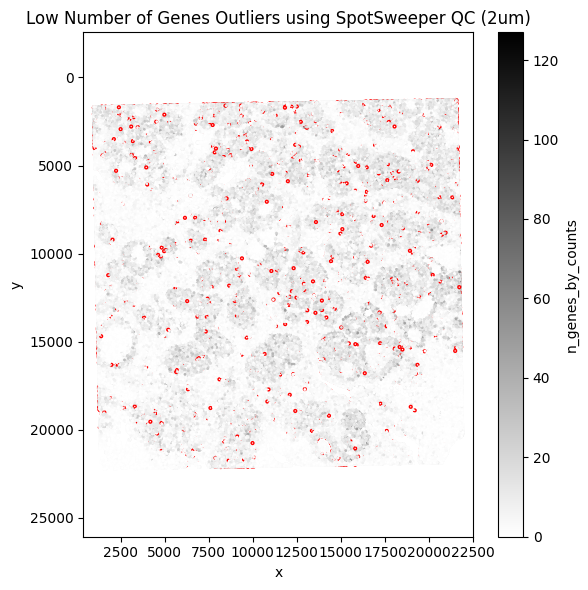

In [44]:
# n genes by counts
lo.local_outliers(bdata, metric = "n_genes_by_counts", sample_key = "region") # compute local outliers
plot_QC.plot_qc_metrics(bdata,"region", metric = "n_genes_by_counts", outliers="n_genes_by_counts_outliers", title = "Low Number of Genes Outliers using SpotSweeper QC (2um)") # plot outliers

In [34]:
col = "n_genes_by_counts_outliers"
print(bdata.obs[col].value_counts())

n_genes_by_counts_outliers
False    10451354
True        83765
Name: count, dtype: int64


83765/(10451354+83765) = 0.8%

**% Mitochondrial Counts**

Spot plot:

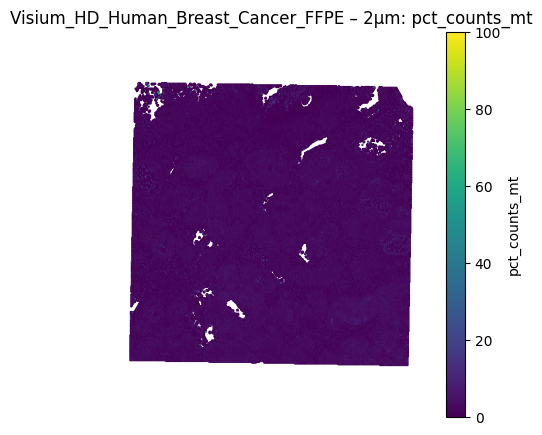

In [35]:
plot_qc_hexbin(
    sdata,
    id="Visium_HD_Human_Breast_Cancer_FFPE",
    metric="pct_counts_mt",
    bin_size=2,
    gridsize=300,  # finer control
    figsize=(5,5)
)

Global QC plot:

Colored = 1,388,139 / 10,535,119 (13.18%)


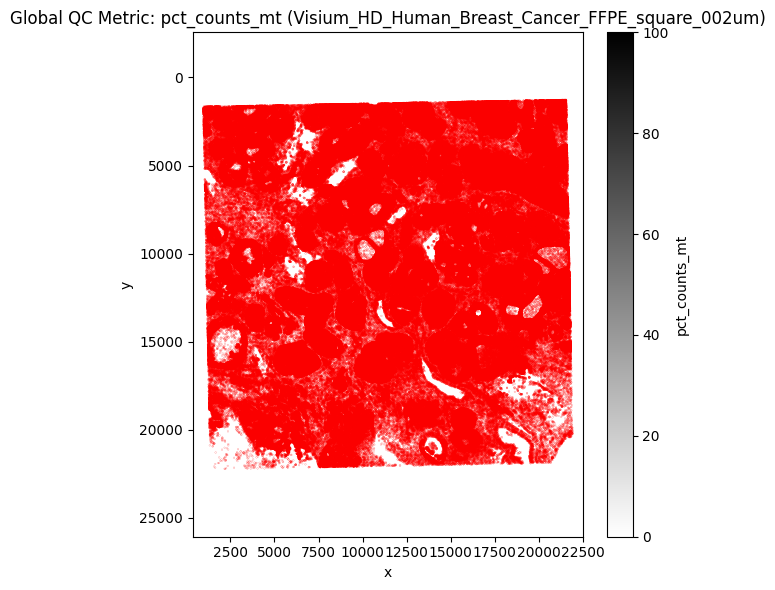

In [36]:
plot_qc_metric_with_outliers(
    adata=bdata,
    sample_id="region",
    sample="Visium_HD_Human_Breast_Cancer_FFPE_square_002um",
    metric="pct_counts_mt",
    outliers="high_mt_outlier",       # boolean column
    point_size=0.1,
    colors=("white", "black"),  # background color gradient
    stroke=0.8,
)
plt.show()

SpotSweeper plot: (Interesting that it flags MINIMAL outliers!)

<module 'matplotlib.pyplot' from '/jhpce/shared/jhpce/core/python/3.9.14/lib/python3.9/site-packages/matplotlib/pyplot.py'>

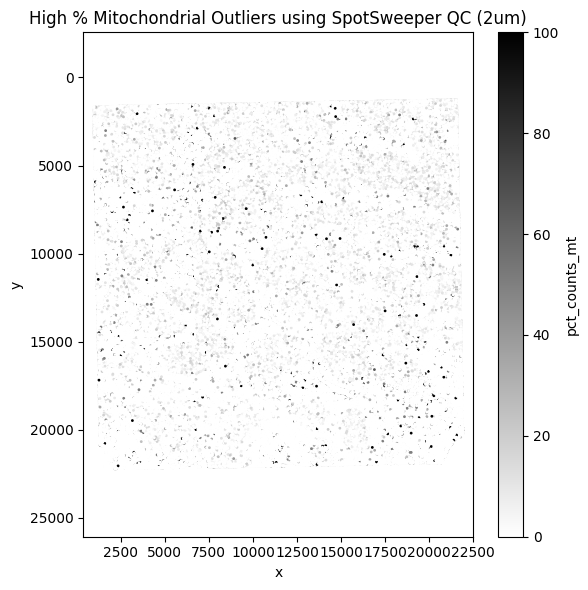

In [46]:
# % mito
lo.local_outliers(bdata, metric = "pct_counts_mt", sample_key = "region") # compute local outliers
plot_QC.plot_qc_metrics(bdata,"region", metric = "pct_counts_mt", outliers="pct_counts_mt_outliers", title = "High % Mitochondrial Outliers using SpotSweeper QC (2um)") # plot outliers

In [38]:
col = "pct_counts_mt_outliers"
print(bdata.obs[col].value_counts())

pct_counts_mt_outliers
False    10534927
True          192
Name: count, dtype: int64


192/(10534927+192) = 0.002%

Violin Plots on 2um scale:

low_counts_outlier
False    10535119
Name: count, dtype: int64
low_log_counts_outlier
False    10535119
Name: count, dtype: int64
high_mt_outlier
False    9146980
True     1388139
Name: count, dtype: int64
low_genes_outlier
False    10535119
Name: count, dtype: int64
all_metrics_outlier
False    9146980
True     1388139
Name: count, dtype: int64


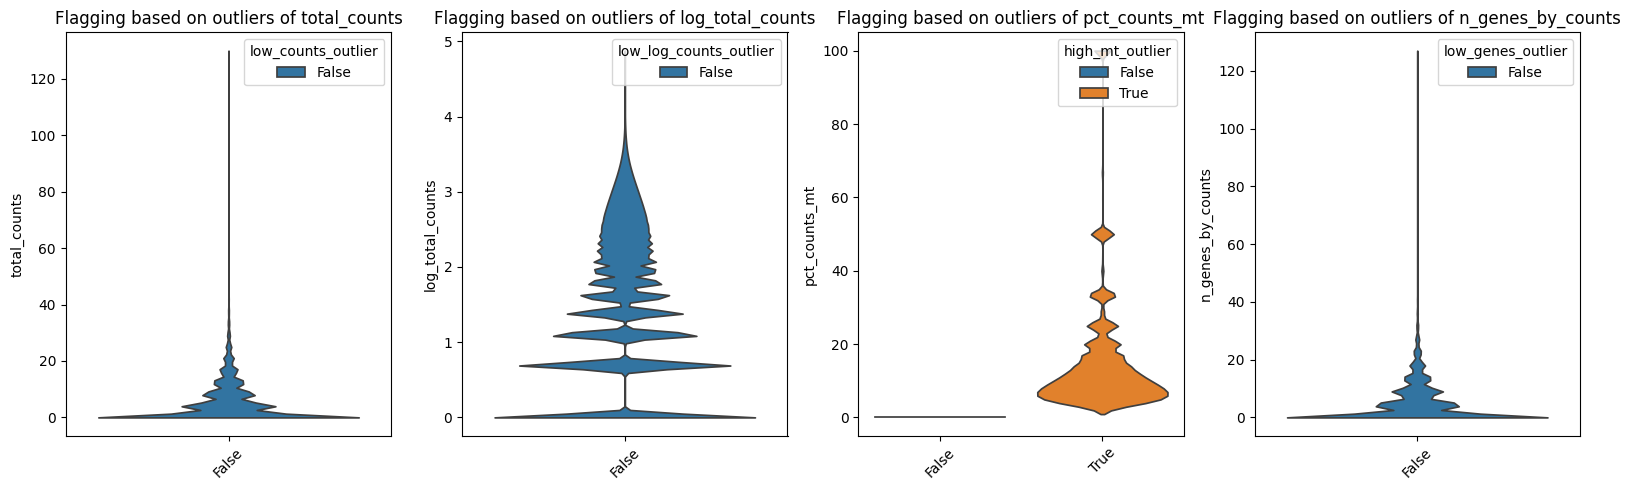

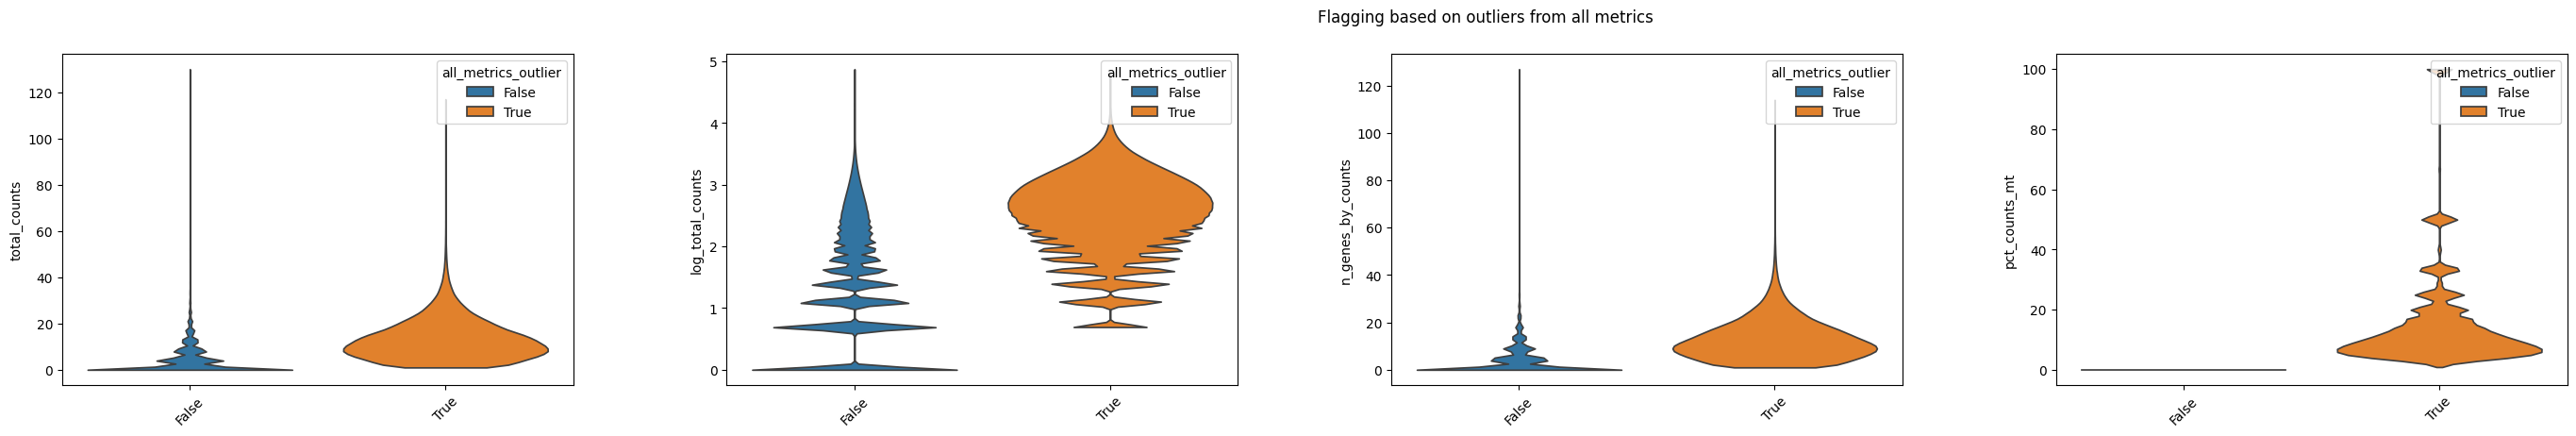

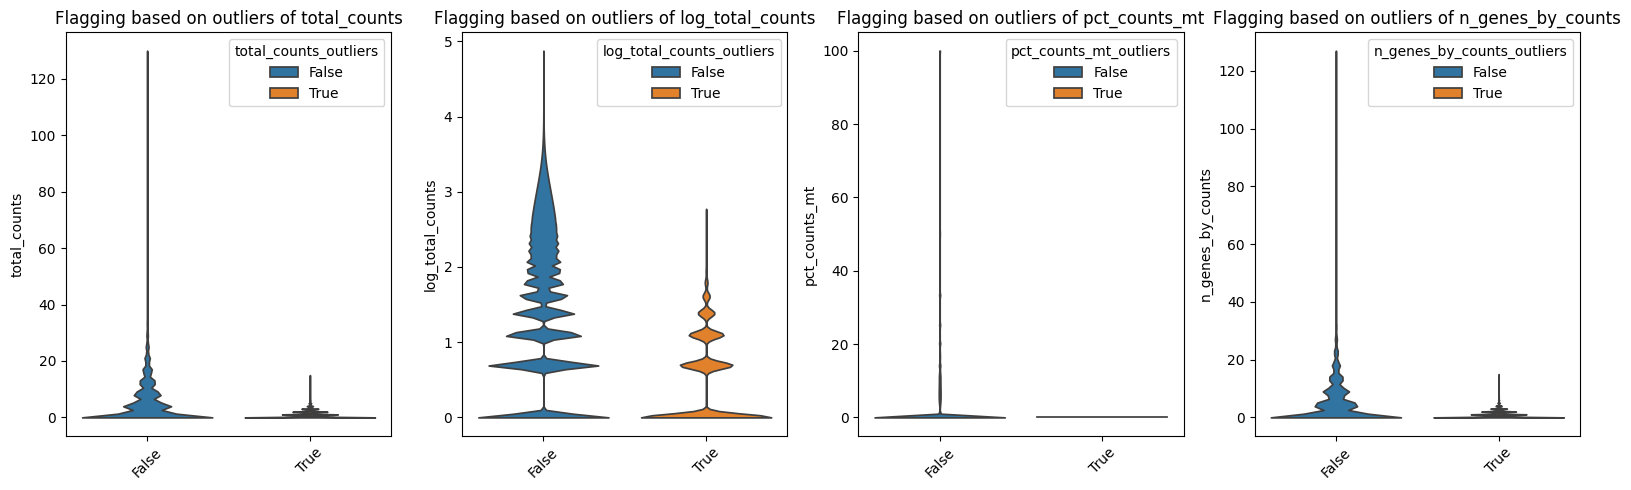

total_counts_outliers
False    10452246
True        82873
Name: count, dtype: int64
log_total_counts_outliers
False    10291025
True       244094
Name: count, dtype: int64
pct_counts_mt_outliers
False    10534927
True          192
Name: count, dtype: int64
n_genes_by_counts_outliers
False    10451354
True        83765
Name: count, dtype: int64
all_local_metrics_outliers
False    10290419
True       244700
Name: count, dtype: int64


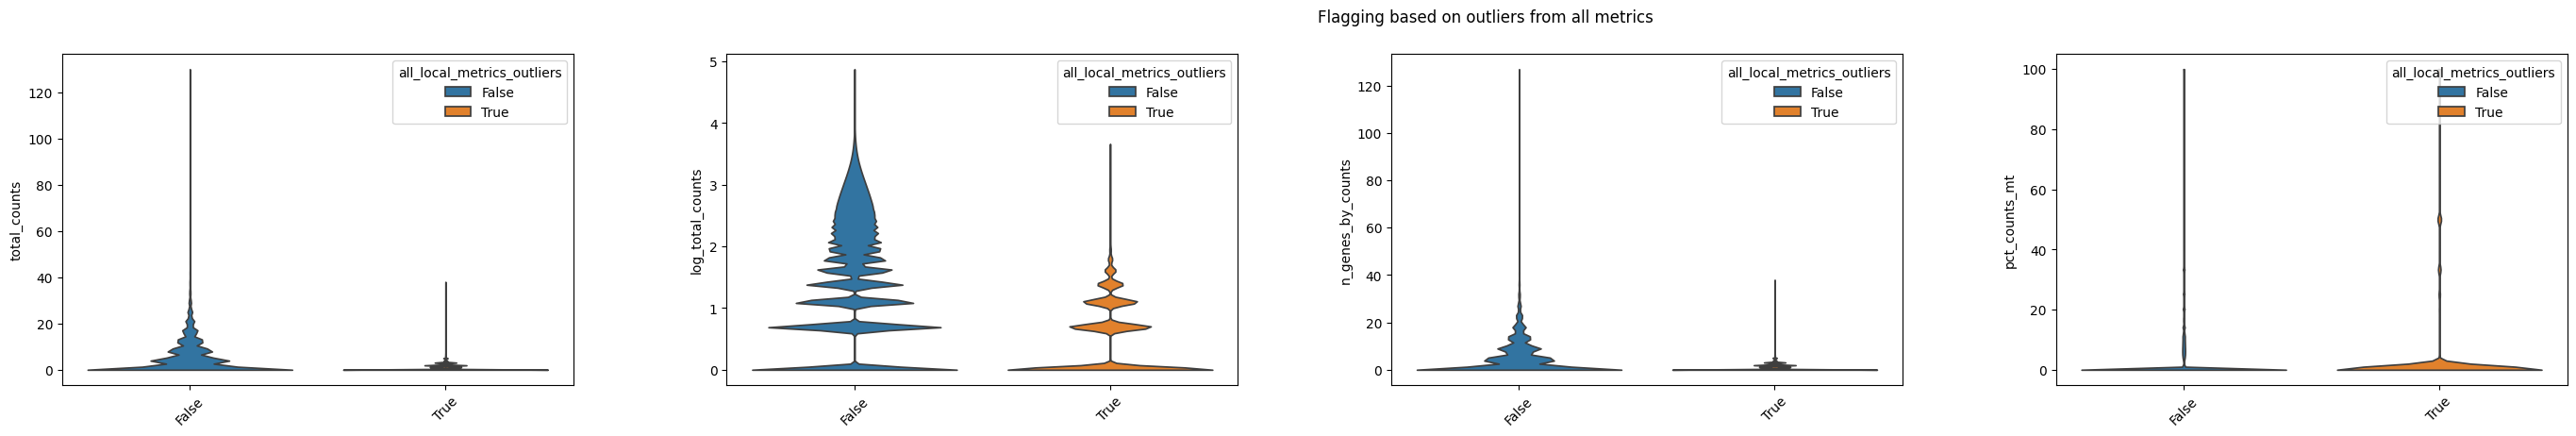

In [43]:
bdata.obs['low_counts_outlier'] = is_outlier(bdata.obs['total_counts'], direction='lower')
bdata.obs['low_log_counts_outlier'] = is_outlier(bdata.obs['log_total_counts'], direction='lower')
bdata.obs['high_mt_outlier']   = is_outlier(bdata.obs['pct_counts_mt'], direction='higher')
bdata.obs['low_genes_outlier'] = is_outlier(bdata.obs['n_genes_by_counts'], direction='lower')

# combine into one global flag
bdata.obs['all_metrics_outlier'] = (
    bdata.obs['low_counts_outlier'] | bdata.obs['low_log_counts_outlier'] | bdata.obs['high_mt_outlier'] | bdata.obs['low_genes_outlier']
)

print(bdata.obs['low_counts_outlier'].value_counts())
print(bdata.obs['low_log_counts_outlier'].value_counts())
print(bdata.obs['high_mt_outlier'].value_counts())
print(bdata.obs['low_genes_outlier'].value_counts())
print(bdata.obs['all_metrics_outlier'].value_counts())


bdata.var_names_make_unique()
for col in ['low_counts_outlier', 'low_log_counts_outlier', 'high_mt_outlier', 'low_genes_outlier']:
    bdata.obs[col] = pd.Categorical(bdata.obs[col])


# Define metric–flag mapping
pairs = [
    ('total_counts', 'low_counts_outlier'),
    ('log_total_counts', 'low_log_counts_outlier'),
    ('pct_counts_mt', 'high_mt_outlier'),
    ('n_genes_by_counts', 'low_genes_outlier')
]

# Create 4-panel figure
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for ax, (metric, flag) in zip(axes, pairs):
    sc.pl.violin(
        bdata,
        keys=metric,
        groupby=flag,
        jitter=0.4,
        stripplot=False,
        rotation=45,
        multi_panel=False,
        ax=ax,
        show=False
    )
    ax.set_title(f"Flagging based on outliers of {metric}")

plt.tight_layout()
plt.show()

bdata.obs['all_metrics_outlier'] = pd.Categorical(bdata.obs['all_metrics_outlier'])

axes = sc.pl.violin(
    bdata,
    keys=['total_counts', 'log_total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
    groupby='all_metrics_outlier',  # group by TRUE/FALSE
    jitter=0.4,
    stripplot=False,
    rotation=45,
    multi_panel=True,
    show = False
)

fig = axes[0].figure
fig.suptitle("Flagging based on outliers from all metrics")
plt.show()

bdata.var_names_make_unique()
for col in ['total_counts_outliers', 'log_total_counts_outliers', 'n_genes_by_counts_outliers', 'pct_counts_mt_outliers']:
    bdata.obs[col] = pd.Categorical(bdata.obs[col])


# Define metric–flag mapping
pairs = [
    ('total_counts', 'total_counts_outliers'),
    ('log_total_counts', 'log_total_counts_outliers'),
    ('pct_counts_mt', 'pct_counts_mt_outliers'),
    ('n_genes_by_counts', 'n_genes_by_counts_outliers')
]

# Create 4-panel figure
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for ax, (metric, flag) in zip(axes, pairs):
    sc.pl.violin(
        bdata,
        keys=metric,
        groupby=flag,
        jitter=0.4,
        stripplot=False,
        rotation=45,
        multi_panel=False,
        ax=ax,
        show=False
    )
    ax.set_title(f"Flagging based on outliers of {metric}")

plt.tight_layout()
plt.show()

# combine into one global flag
bdata.obs['all_local_metrics_outliers'] = (
    bdata.obs['total_counts_outliers'].astype(bool) | bdata.obs['log_total_counts_outliers'].astype(bool) | bdata.obs['pct_counts_mt_outliers'].astype(bool) | bdata.obs['n_genes_by_counts_outliers'].astype(bool)
)

print(bdata.obs['total_counts_outliers'].value_counts())
print(bdata.obs['log_total_counts_outliers'].value_counts())
print(bdata.obs['pct_counts_mt_outliers'].value_counts())
print(bdata.obs['n_genes_by_counts_outliers'].value_counts())
print(bdata.obs['all_local_metrics_outliers'].value_counts())

bdata.obs['all_local_metrics_outliers'] = pd.Categorical(bdata.obs['all_local_metrics_outliers'])

axes = sc.pl.violin(
    bdata,
    keys=['total_counts', 'log_total_counts', 'n_genes_by_counts', 'pct_counts_mt'],
    groupby='all_local_metrics_outliers',  # group by TRUE/FALSE
    jitter=0.4,
    stripplot=False,
    rotation=45,
    multi_panel=True,
    show = False
)

fig = axes[0].figure
fig.suptitle("Flagging based on outliers from all metrics")
plt.show()